<a href="https://colab.research.google.com/github/gilbert-umuzi/donor-lifetime-value-analysis/blob/main/donor_ltv_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonprofit Donor Lifetime Value Analysis

This project analyzes donor data for a nonprofit organization to develop a Lifetime Value (LTV) model. The goal is to understand donor behavior, segment donors, and predict their long-term value to the organization. This analysis can inform fundraising strategies and help optimize resource allocation for donor acquisition and retention.

Libraries used: pandas, numpy, matplotlib, seaborn, scikit-learn, statsmodels, lifelines

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import classification_report

%matplotlib inline
plt.style.use('seaborn')

## Data Loading and Cleaning

In this section, we load the donor data from a CSV file and perform necessary cleaning steps. This includes:
- Renaming columns for clarity
- Converting dollar amounts to numerical values
- Handling date columns
- Calculating total gifts for each donor

The cleaned dataset provides a solid foundation for our subsequent analysis.

In [3]:
# 1. Data Loading and Cleaning

def load_data(file_path):
    """Load the donor data from a CSV file."""
    return pd.read_csv(file_path)

def clean_data(df):
    """Clean and preprocess the donor data."""
    # Rename columns
    df = df.rename(columns={'Totan donations in 2022': 'Total donations in 2022',
                            'Was their first donation an automatically-recurring transaction?': 'recurring'})

    # Convert dollar columns to numerical (float)
    dollar_columns = ['Total donations in 2017', 'Total donations in 2018',
                      'Total donations in 2019', 'Total donations in 2020',
                      'Total donations in 2021', 'Total donations in 2022',
                      'Total donations in 2023', 'Amount of first donation',
                      'Amount of last donation', 'Highest amount donated in one year']

    def dollar_to_float(dollar_str):
        if isinstance(dollar_str, str):
            return round(float(dollar_str.replace('$', '').replace(',', '')), 2)
        return dollar_str

    for column in dollar_columns:
        df[column] = df[column].apply(dollar_to_float)

    # Convert date columns to datetime
    date_columns = ['Date of first donation', 'Date of last donation']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Handle missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna('Unknown')
        else:
            df[column] = df[column].fillna(0)

    # Create 'Total Gifts' column
    donation_columns = [f'Total donations in {year}' for year in range(2017, 2024)]
    df['Total Gifts'] = df[donation_columns].sum(axis=1)

    return df

# Load and clean the data
df = load_data('/content/donor_data.csv')
df = clean_data(df)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2524 entries, 0 to 2523
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Unique donor ID                     2524 non-null   object        
 1   Total donations in 2017             2524 non-null   float64       
 2   Total donations in 2018             2524 non-null   float64       
 3   Total donations in 2019             2524 non-null   float64       
 4   Total donations in 2020             2524 non-null   float64       
 5   Total donations in 2021             2524 non-null   float64       
 6   Total donations in 2022             2524 non-null   float64       
 7   Total donations in 2023             2524 non-null   float64       
 8   Amount of first donation            2524 non-null   float64       
 9   Date of first donation              2524 non-null   datetime64[ns]
 10  recurring               

,Unique donor ID,Total donations in 2017,Total donations in 2018,Total donations in 2019,Total donations in 2020,Total donations in 2021,Total donations in 2022,Total donations in 2023,Amount of first donation,Date of first donation,recurring,Amount of last donation,Date of last donation,Year with the most dollars donated,Highest amount donated in one year,Total Gifts
0,0031Y00005xkHT8QAM,0.0,0.0,700.0,2400.0,2000.0,1500.0,1500.0,700.0,2019-12-30,0,1000.0,2023-09-15,2020,2400.0,8100.0
1,0031Y00005WVHv9QAH,0.0,35.0,0.0,0.0,0.0,0.0,0.0,35.0,2018-12-20,0,35.0,2018-12-20,2018,35.0,35.0
2,0031Y00005xkID5QAM,0.0,0.0,44840.0,0.0,50000.0,50.0,40000.0,14840.0,2019-12-06,0,15000.0,2024-02-28,2021,50000.0,134890.0
3,0031Y00005epCTZQA2,0.0,0.0,120.0,80.0,0.0,0.0,0.0,10.0,2019-02-26,1,10.0,2020-09-26,2019,120.0,200.0
4,0031Y00005epDY3QAM,0.0,0.0,216.0,0.0,0.0,0.0,0.0,16.0,2019-02-26,0,200.0,2019-12-20,2019,216.0,216.0


## Exploratory Data Analysis

Our EDA reveals several key insights about the donor base:

1. The distribution of total gifts is highly skewed, with a large number of small donors and a few very large donors.
2. There's a general upward trend in total donations from 2017 to 2023, with some year-to-year fluctuations.
3. Recurring donors make up a small but significant portion of the donor base.
4. First donation amounts also follow a skewed distribution, suggesting the importance of cultivating major donors.

These insights inform our subsequent analysis and modeling approaches.

       Total donations in 2017  Total donations in 2018  \
count              2524.000000              2524.000000   
mean                229.333597                92.664422   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              200000.000000             21099.000000   
std                4608.939216               822.790411   

       Total donations in 2019  Total donations in 2020  \
count              2524.000000              2524.000000   
mean                164.333597               221.938312   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                20.467500   
max               44840.000000             41350.000000

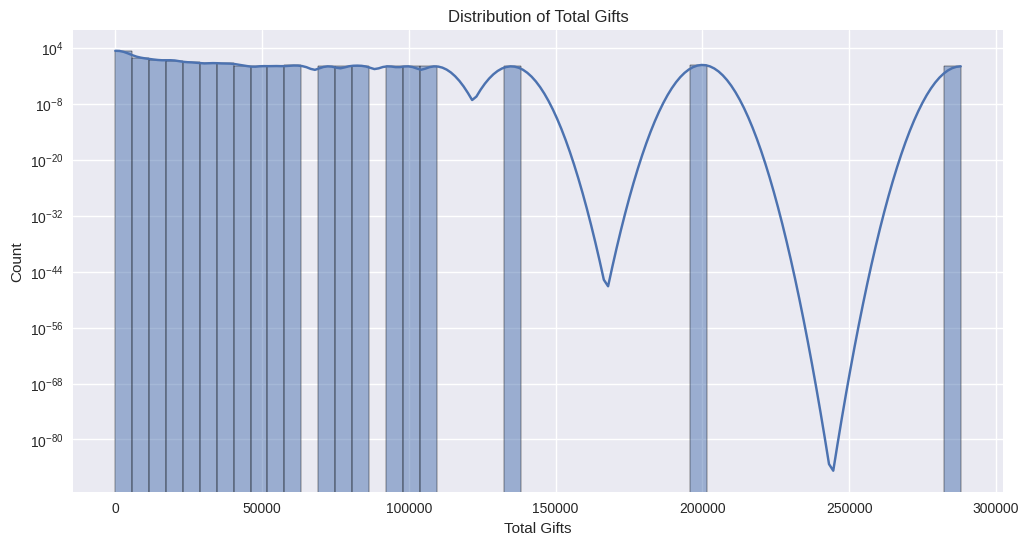

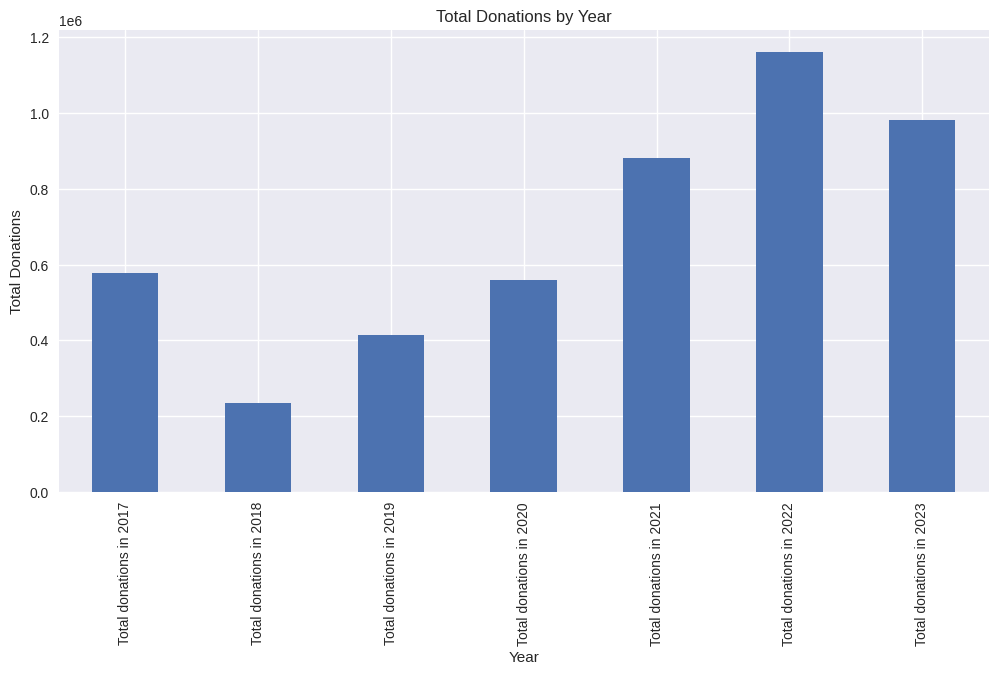

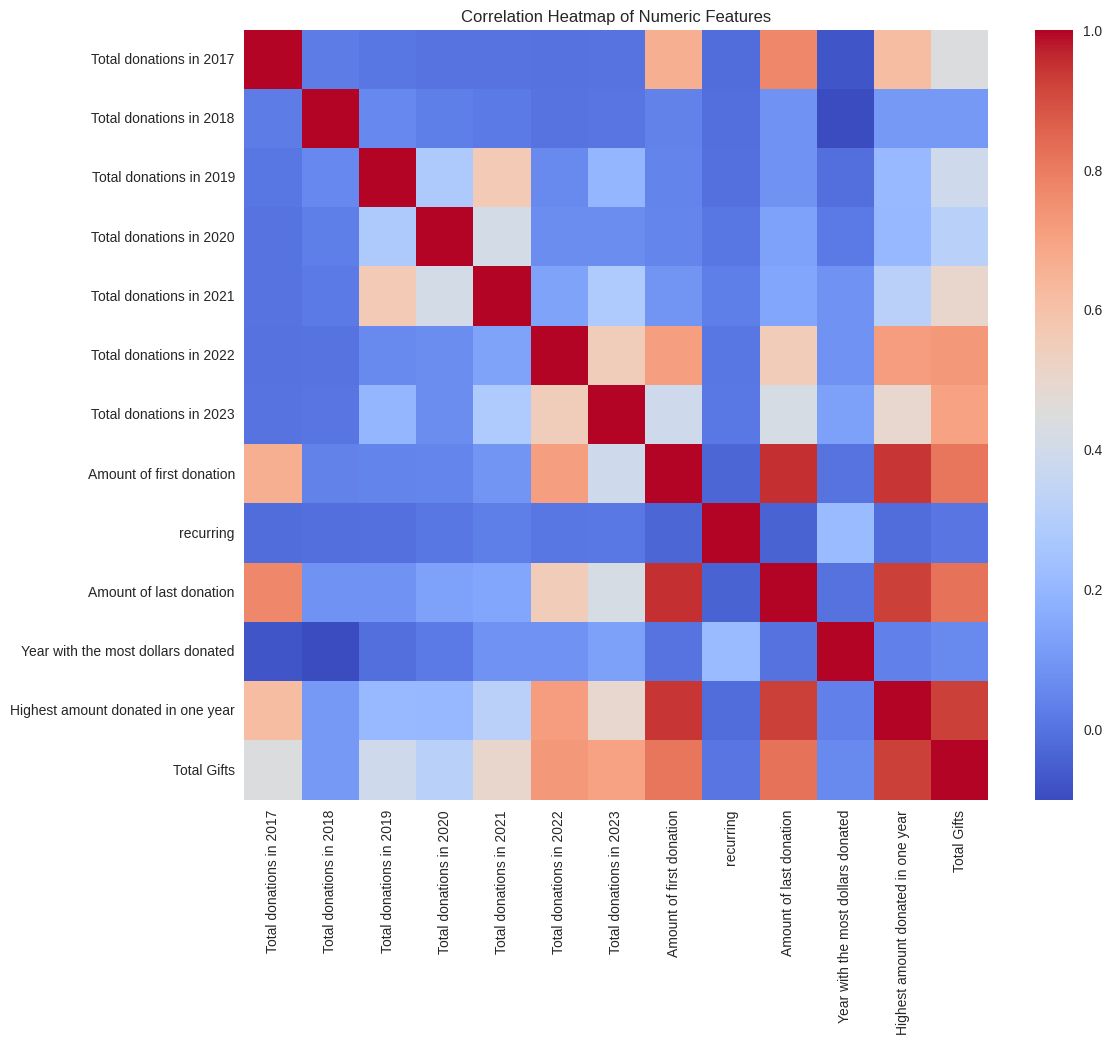

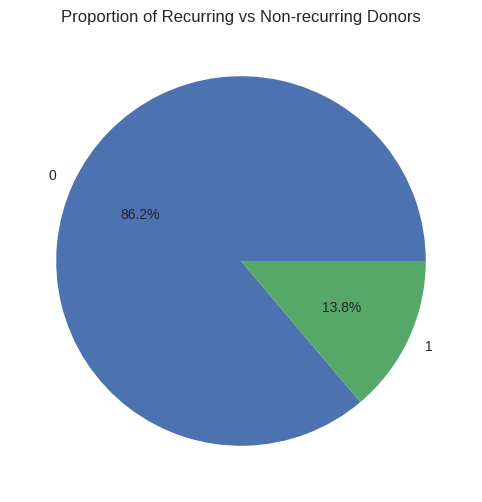

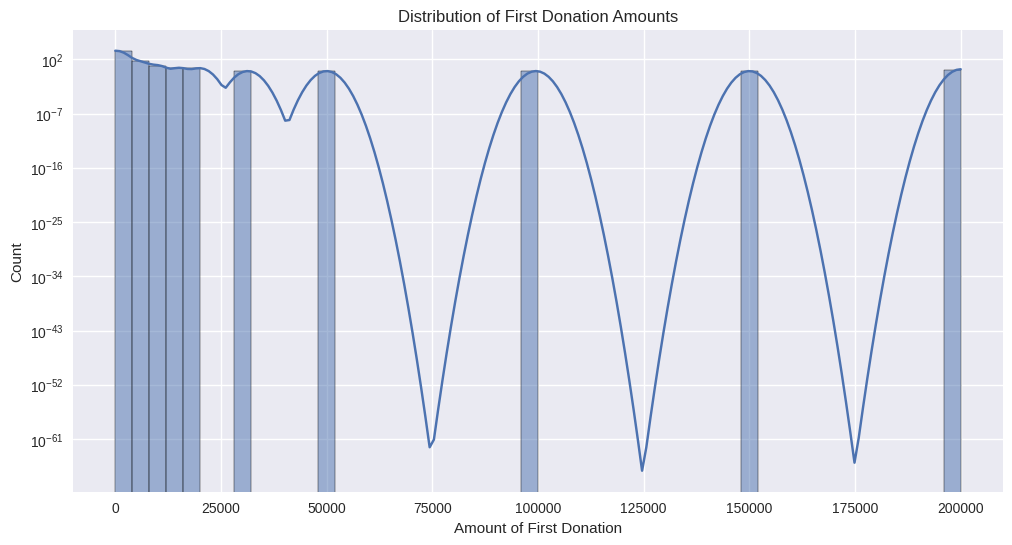

In [4]:
# 2. Exploratory Data Analysis (EDA)

def perform_eda(df):
    """Perform exploratory data analysis on the donor data."""
    # Summary statistics
    print(df.describe())

    # Distribution of total gifts
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Total Gifts'], bins=50, kde=True)
    plt.title('Distribution of Total Gifts')
    plt.xlabel('Total Gifts')
    plt.yscale('log')  # Use log scale for y-axis due to skewed distribution
    plt.show()

    # Donation trends over time
    yearly_donations = df[[f'Total donations in {year}' for year in range(2017, 2024)]].sum()
    plt.figure(figsize=(12, 6))
    yearly_donations.plot(kind='bar')
    plt.title('Total Donations by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Donations')
    plt.show()

    # Correlation heatmap
    corr_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    corr_matrix = df[corr_columns].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

    # Recurring vs non-recurring donors
    recurring_counts = df['recurring'].value_counts()
    plt.figure(figsize=(8, 6))
    recurring_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Proportion of Recurring vs Non-recurring Donors')
    plt.ylabel('')
    plt.show()

    # Distribution of first donation amounts
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Amount of first donation'], bins=50, kde=True)
    plt.title('Distribution of First Donation Amounts')
    plt.xlabel('Amount of First Donation')
    plt.yscale('log')
    plt.show()

perform_eda(df)

## Donor Segmentation

We segment donors into three categories based on their average annual donation (USD):
- Small: < 1,000
- Medium: 1,000 - 10,000
- Large: > 10,000

Key findings:
- The majority of donors fall into the "Small" category
- "Large" donors, while few in number, contribute a disproportionate amount to total donations
- "Medium" donors represent a significant opportunity for growth

This segmentation will be crucial for tailoring retention strategies and estimating Lifetime Value.

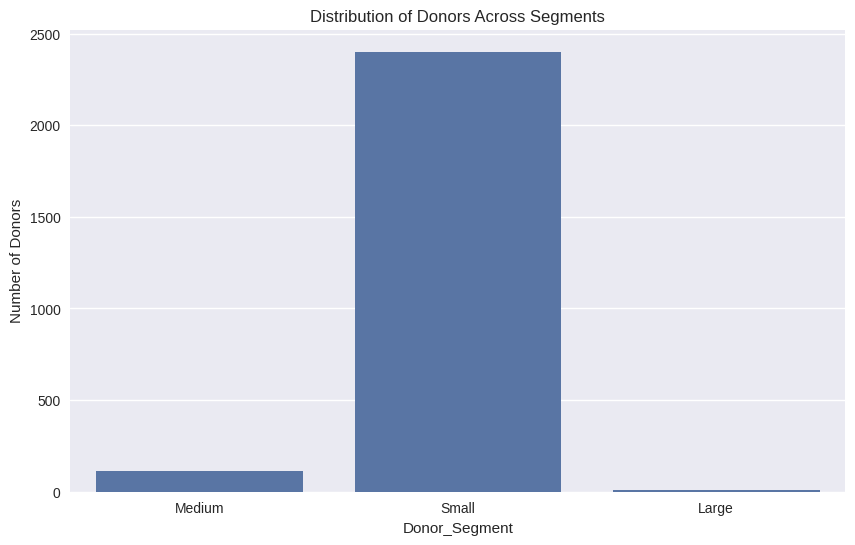

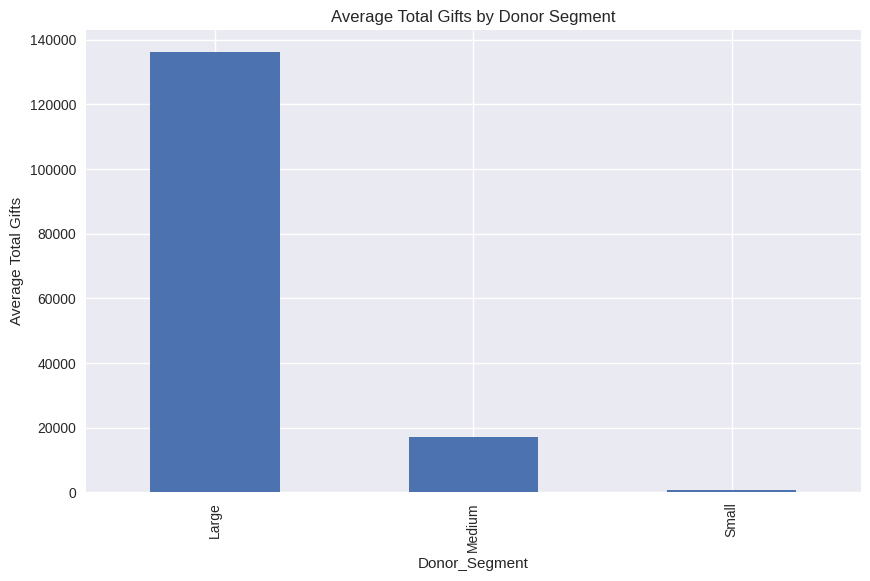

              Unique donor ID Total Gifts avg_annual_donation          
                        count         sum                mean    median
Donor_Segment                                                          
Large                      10  1361558.30            19450.83  14892.16
Medium                    113  1938689.78             2450.94   1869.60
Small                    2401  1512915.17               90.02     21.43


In [5]:
# 3. Donor Segmentation
def segment_donors(df):
    """
    Segment donors based on their average annual donation amount.
    """
    # Calculate average annual donation
    year_columns = [f'Total donations in {year}' for year in range(2017, 2024)]
    df['avg_annual_donation'] = df[year_columns].mean(axis=1)

    # Define segmentation function
    def assign_segment(amount):
        if amount < 1000:
          return 'Small'
        elif amount <= 10000:
          return 'Medium'
        else:
          return 'Large'

    def four_segment_donation(amount):
        if amount <= 10000:
            return 'Small'
        elif amount <= 100000:
            return 'Medium'
        elif amount <= 1000000:
            return 'Large'
        else:
            return 'Major'

    # Apply segmentation
    df['Donor_Segment'] = df['avg_annual_donation'].apply(assign_segment)
    # df['Donor_Segment'] = df['avg_annual_donation'].apply(four_segment_donation)

    # Visualize segmentation
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Donor_Segment', data=df)
    plt.title('Distribution of Donors Across Segments')
    plt.ylabel('Number of Donors')
    plt.show()

    # Calculate average total gifts by segment
    segment_avg_gifts = df.groupby('Donor_Segment')['Total Gifts'].mean().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    segment_avg_gifts.plot(kind='bar')
    plt.title('Average Total Gifts by Donor Segment')
    plt.ylabel('Average Total Gifts')
    plt.show()

    return df

# Apply segmentation
df = segment_donors(df)

# Display segment statistics
print(df.groupby('Donor_Segment').agg({
    'Unique donor ID': 'count',
    'Total Gifts': 'sum',
    'avg_annual_donation': ['mean', 'median']
}).round(2))

## Retention Analysis

Our retention analysis reveals:
- Overall retention rates have improved from 2017 to 2023
- Larger donors tend to have higher retention rates
- There's significant room for improvement in retaining small donors

These insights suggest that targeted retention strategies for each segment could significantly impact the organization's long-term fundraising success.

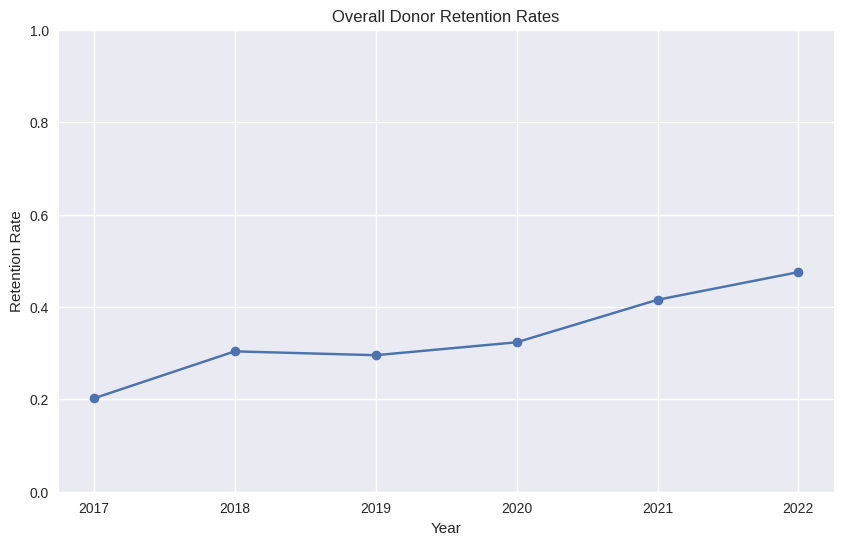

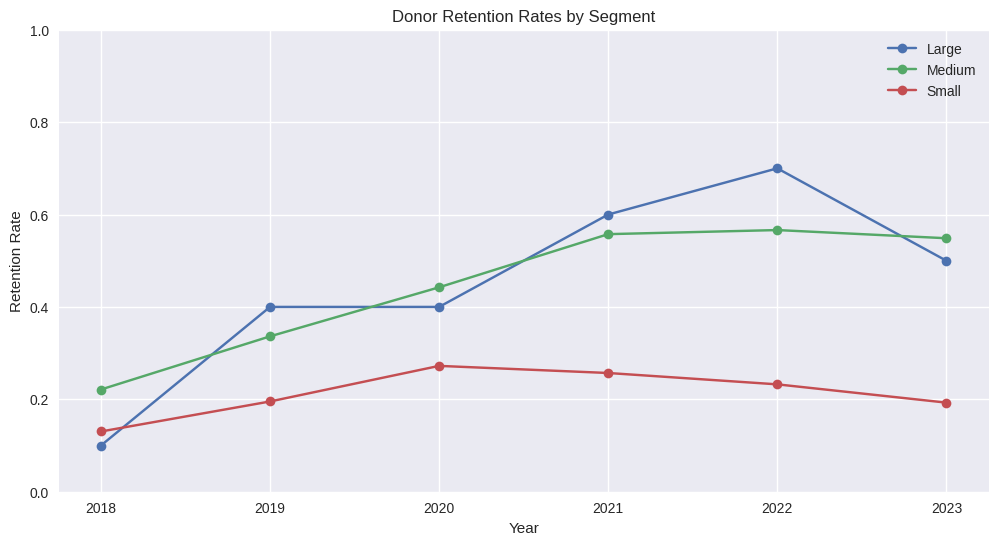

Overall Retention Rates: {2017: 0.20212765957446807, 2018: 0.30383480825958703, 2019: 0.29549902152641877, 2020: 0.3234463276836158, 2021: 0.41545189504373176, 2022: 0.4753577106518283}

Segment Retention Rates:
                    2018      2019      2020      2021      2022      2023
Donor_Segment                                                            
Large          0.100000  0.400000  0.400000  0.600000  0.700000  0.500000
Medium         0.221239  0.336283  0.442478  0.557522  0.566372  0.548673
Small          0.130362  0.195335  0.272387  0.256976  0.232403  0.192836


In [6]:
# 4. Retention Analysis
def analyze_retention(df):
    """
    Analyze donor retention rates over time and by segment.
    """
    def calculate_retention_rate(group):
        return group.sum() / len(group)

    # Calculate retention rates by year
    retention_rates = {}
    for year in range(2017, 2023):  # We can't calculate retention for 2023 yet
        current_year_donors = df[df[f'Total donations in {year}'] > 0]
        next_year_donors = df[df[f'Total donations in {year + 1}'] > 0]
        retained_donors = current_year_donors[current_year_donors['Unique donor ID'].isin(next_year_donors['Unique donor ID'])]
        retention_rate = len(retained_donors) / len(current_year_donors)
        retention_rates[year] = retention_rate

    # Plot overall retention rates
    plt.figure(figsize=(10, 6))
    plt.plot(list(retention_rates.keys()), list(retention_rates.values()), marker='o')
    plt.title('Overall Donor Retention Rates')
    plt.xlabel('Year')
    plt.ylabel('Retention Rate')
    plt.ylim(0, 1)
    plt.show()

    # Calculate retention rates by segment
    segment_retention = df.groupby('Donor_Segment').apply(lambda x: pd.Series({
        year: calculate_retention_rate(x[f'Total donations in {year}'] > 0)
        for year in range(2018, 2024)
    }))

    # Plot retention rates by segment
    plt.figure(figsize=(12, 6))
    for segment in segment_retention.index:
        plt.plot(segment_retention.columns, segment_retention.loc[segment], marker='o', label=segment)
    plt.title('Donor Retention Rates by Segment')
    plt.xlabel('Year')
    plt.ylabel('Retention Rate')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

    return retention_rates, segment_retention

# Analyze retention
overall_retention, segment_retention = analyze_retention(df)
print("Overall Retention Rates:", overall_retention)
print("\nSegment Retention Rates:\n", segment_retention)

## Seasonal Trends

The analysis of seasonal donation patterns shows:
- A strong peak in donations during December (likely due to year-end giving)
- A smaller peak in donations during the middle of the year (possibly related to fiscal year-end for some donors)
- Different seasonal patterns across donor segments

Understanding these trends can help in planning fundraising campaigns and communications throughout the year.

datetime64[ns]
  Date of last donation  Last_Donation_Month  Last_Donation_Quarter
0            2023-09-15                    9                      3
1            2018-12-20                   12                      4
2            2024-02-28                    2                      1
3            2020-09-26                    9                      3
4            2019-12-20                   12                      4


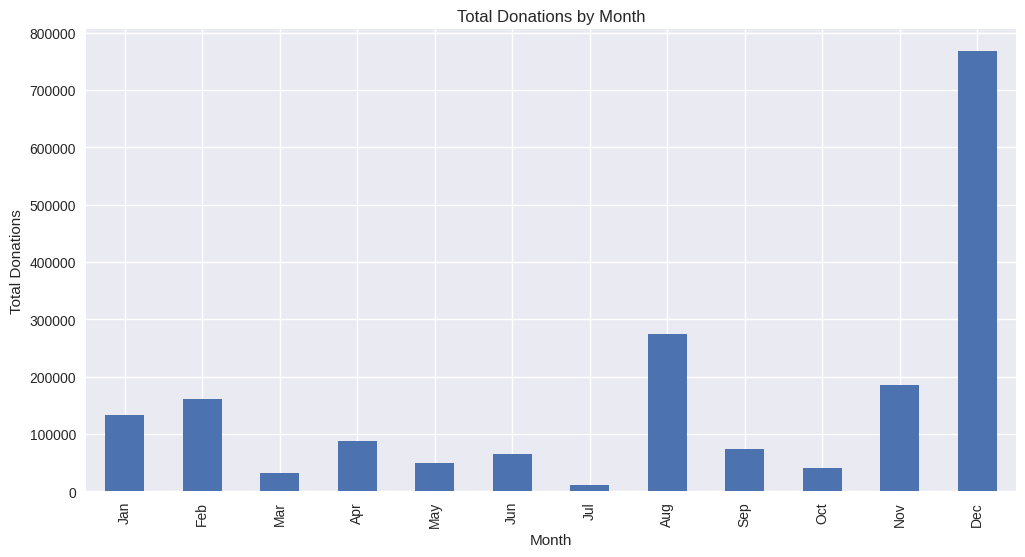

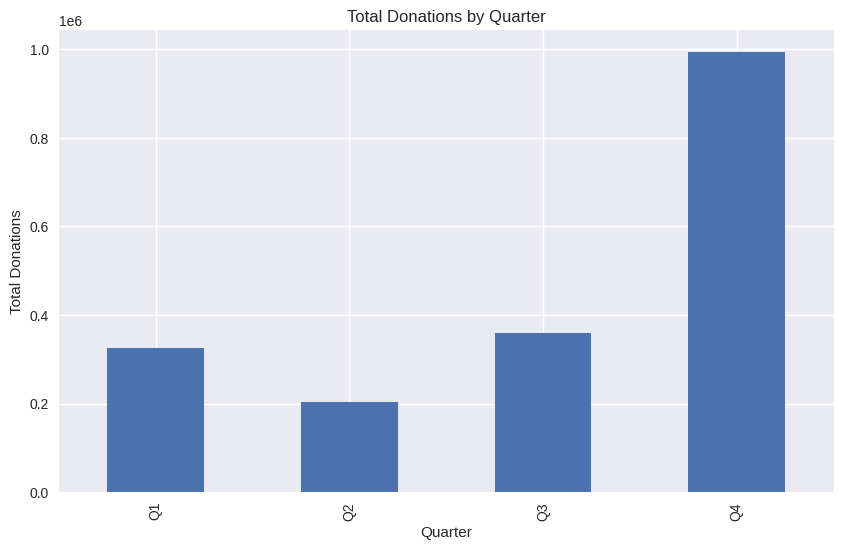

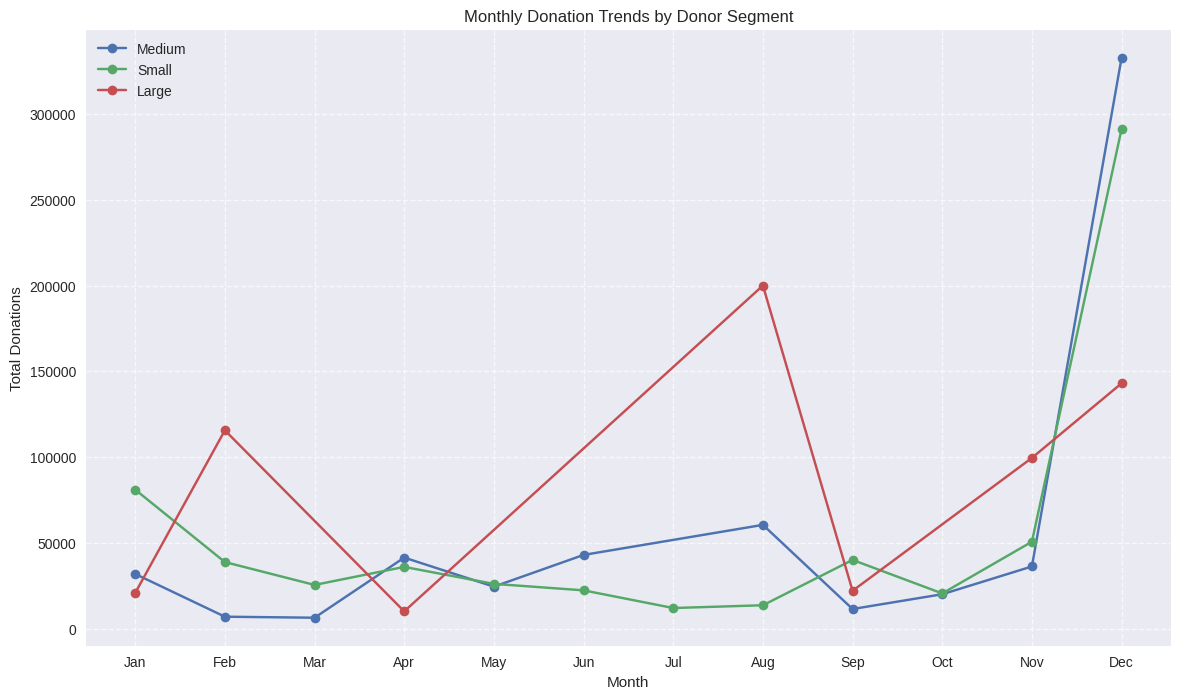

Monthly Donation Trends:
 Last_Donation_Month
1     133549.32
2     161242.45
3      31727.66
4      87303.22
5      50456.89
6      65194.76
7      11959.69
8     274021.45
9      73386.94
10     40467.62
11    186315.81
12    767160.48
Name: Amount of last donation, dtype: float64

Quarterly Donation Trends:
 Last_Donation_Quarter
1    326519.43
2    202954.87
3    359368.08
4    993943.91
Name: Amount of last donation, dtype: float64


In [7]:
# 5. Seasonal Trends
def analyze_seasonal_trends(df):
    """
    Analyze and visualize seasonal trends in donations.
    """
    # Ensure the date columns are datetime
    df['Date of last donation'] = pd.to_datetime(df['Date of last donation'], errors='coerce')

    # Debugging: Check data types
    print(df['Date of last donation'].dtype)

    # Extract month and quarter from the last donation date
    df['Last_Donation_Month'] = df['Date of last donation'].dt.month
    df['Last_Donation_Quarter'] = df['Date of last donation'].dt.quarter

    # Debugging: Check if extraction was successful
    print(df[['Date of last donation', 'Last_Donation_Month', 'Last_Donation_Quarter']].head())

    # Monthly donation trends
    monthly_donations = df.groupby('Last_Donation_Month')['Amount of last donation'].sum()

    plt.figure(figsize=(12, 6))
    monthly_donations.plot(kind='bar')
    plt.title('Total Donations by Month')
    plt.xlabel('Month')
    plt.ylabel('Total Donations')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

    # Quarterly donation trends
    quarterly_donations = df.groupby('Last_Donation_Quarter')['Amount of last donation'].sum()

    plt.figure(figsize=(10, 6))
    quarterly_donations.plot(kind='bar')
    plt.title('Total Donations by Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Total Donations')
    plt.xticks(range(4), ['Q1', 'Q2', 'Q3', 'Q4'])
    plt.show()

    # Seasonal trends by donor segment
    plt.figure(figsize=(14, 8))
    for segment in df['Donor_Segment'].unique():
        segment_data = df[df['Donor_Segment'] == segment]
        monthly_segment_donations = segment_data.groupby('Last_Donation_Month')['Amount of last donation'].sum()
        plt.plot(monthly_segment_donations.index, monthly_segment_donations.values, label=segment, marker='o')

    plt.title('Monthly Donation Trends by Donor Segment')
    plt.xlabel('Month')
    plt.ylabel('Total Donations')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return monthly_donations, quarterly_donations

# Analyze seasonal trends
monthly_trends, quarterly_trends = analyze_seasonal_trends(df)
print("Monthly Donation Trends:\n", monthly_trends)
print("\nQuarterly Donation Trends:\n", quarterly_trends)

## Lifetime Value (LTV) Model

We developed a two-stage model to estimate donor Lifetime Value:
1. A regression model to predict average annual donations
2. A segment-based approach to estimate donor lifespan

Key components of the LTV calculation:
- Historical donations
- Predicted future annual donations
- Estimated remaining lifespan based on donor segment

This model allows us to estimate the long-term value of both existing and newly acquired donors, which is crucial for assessing the ROI of fundraising efforts.

Model fit:
- Log-linear regression for annual donation prediction (R² = 0.871, MSE = 0.465)
- Segment-based donor lifespan estimation, capped at 10 years

Key predictors (log-transformed model):
- First donation amount (coef: 0.7648)
- Recurring status (coef: 0.6617)
- Returning donor status (coef: 0.9772)
- Donor relationship duration (coef: 0.4825)
- Segment (Medium: 1.0949, Large: 1.2037)

Model diagnostics:
- Low multicollinearity (VIF < 2 for all features)
- Non-normal residuals (significant Jarque-Bera test)

This model allows us to estimate the long-term value of both existing and newly acquired donors, which is crucial for assessing the ROI of fundraising efforts.

Future improvements to enhance the model and analysis:
- Address non-normal residuals through alternative modeling techniques
- Validate with long-term donor data if available
- Consider advanced techniques such as survival analysis or time series forecasting
- Incorporate external factors (e.g., economic indicators) that might influence donation patterns
- Develop a more sophisticated segmentation strategy based on behavioral and demographic factors

### OLS

log_amount_of_first_donation dtype: float64
recurring dtype: int64
returning_donor dtype: int64
duration_scaled dtype: float64
Segment_Medium dtype: int64
Segment_Large dtype: int64
       log_amount_of_first_donation    recurring  returning_donor  \
count                   2524.000000  2524.000000      2524.000000   
mean                       4.380645     0.138273         0.389857   
std                        1.775980     0.345254         0.487814   
min                        0.019803     0.000000         0.000000   
25%                        3.258097     0.000000         0.000000   
50%                        4.235119     0.000000         0.000000   
75%                        5.525453     0.000000         1.000000   
max                       12.206078     1.000000         1.000000   

       duration_scaled  Segment_Medium  Segment_Large  log_avg_annual_donation  
count     2.524000e+03      2524.00000    2524.000000              2524.000000  
mean      6.756349e-17         0.0

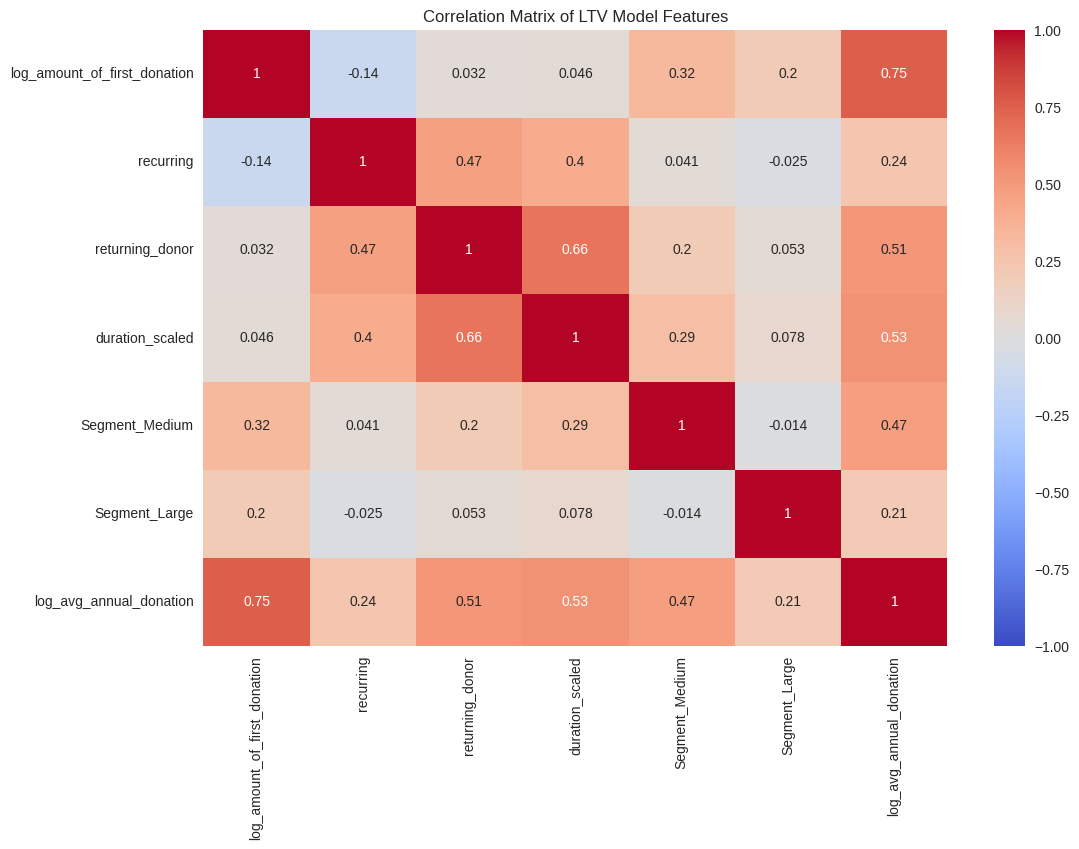


Retention Rates by Segment:
Donor_Segment
Large     0.500000
Medium    0.548673
Small     0.192836
dtype: float64

Predicted LTV for a new Medium donor with a $500 first donation and recurring status: $2961.43


In [11]:
def calculate_vif(X):
    """Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame."""
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

def develop_ltv_model(df):
    """
    Develop a Lifetime Value (LTV) model for donors using log-transformed values and additional features.
    """

    # Feature engineering
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['Date of last donation'] = pd.to_datetime(df['Date of last donation'])
    df['Date of first donation'] = pd.to_datetime(df['Date of first donation'])
    df['duration'] = (df['Date of last donation'] - df['Date of first donation']).dt.days
    df['Month of last donation'] = df['Date of last donation'].dt.month
    df['donation_frequency'] = df[[f'Total donations in {year}' for year in range(2017, 2024)]].gt(0).sum(axis=1)
    df['time_between_donations'] = df['duration'] / df['donation_frequency']
    df['time_between_donations'].replace(np.inf, np.nan, inplace=True)
    df['time_between_donations'].fillna(0, inplace=True)
    df['returning_donor'] = (df['Date of last donation'] != df['Date of first donation']).astype(int)

    # One-hot encode donor segments, dropping Segment_Small to avoid multicollinearity
    segment_dummies = pd.get_dummies(df['Donor_Segment'], prefix='Segment', drop_first=False)
    segment_dummies = segment_dummies.drop('Segment_Small', axis=1)
    df = pd.concat([df, segment_dummies], axis=1)

    # Standardize 'duration'
    scaler = StandardScaler()
    df['duration_scaled'] = scaler.fit_transform(df[['duration']])

    # Log-transform Amount of first donation and avg_annual_donation
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['log_avg_annual_donation'] = np.log1p(df['avg_annual_donation'])

    # Modify features list
    features = ['log_amount_of_first_donation', 'recurring',
                'returning_donor', 'duration_scaled']

    # Add segment columns that exist in the dataframe
    for col in ['Segment_Medium', 'Segment_Large']:
        if col in df.columns:
            features.append(col)
            df[col] = df[col].astype(int)  # Convert boolean to int

    # Ensure all features are numeric and print data types
    for feature in features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
        print(f"{feature} dtype: {df[feature].dtype}")

    # Print summary statistics and check for NaN values
    print(df[features + ['log_avg_annual_donation']].describe())
    print("\nNaN values:\n", df[features + ['log_avg_annual_donation']].isna().sum())

    # Drop rows with NaN values
    df_clean = df.dropna(subset=features + ['log_avg_annual_donation'])

    # Prepare the target variable (log-transformed average annual donation)
    X = df_clean[features]
    y = df_clean['log_avg_annual_donation']

    # Add constant for statsmodels
    X = sm.add_constant(X)

    # Print first few rows of X and y to verify data
    print("\nFirst few rows of X:")
    print(X.head())
    print("\nFirst few values of y:")
    print(y.head())

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the average annual donation model using statsmodels
    avg_donation_model = sm.OLS(y_train, X_train).fit()

    # Make predictions on the test set
    y_pred = avg_donation_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Log-transformed Average Annual Donation Model:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    print(avg_donation_model.summary())

    # Calculate VIF for features
    vif = calculate_vif(X_train)
    print("\nVariance Inflation Factors (VIF):")
    print(vif)

    # Calculate retention rates for each segment
    retention_rates = df.groupby('Donor_Segment').apply(
        lambda x: (x['Total donations in 2023'] > 0).mean()
    )

    # Function to estimate remaining lifespan based on segment
    def estimate_remaining_lifespan(segment):
        return 1 / (1 - retention_rates[segment])

    # Function to predict LTV
    def predict_ltv(first_donation, recurring, returning_donor, duration, segment, historical_donations=0):
      # Prepare input data
      input_data = {
          'const': 1,
          'log_amount_of_first_donation': np.log1p(first_donation),
          'recurring': recurring,
          'returning_donor': returning_donor,
          'duration_scaled': (duration - df['duration'].mean()) / df['duration'].std()  # Scale duration
      }

      # Add segment columns
      for col in ['Segment_Medium', 'Segment_Large']:
          input_data[col] = 1 if segment == col.split('_')[1] else 0

      input_df = pd.DataFrame([input_data])

      # Predict average annual donation (log-transformed)
      log_avg_annual_donation = avg_donation_model.predict(input_df)[0]

      # Convert back from log scale
      avg_annual_donation = np.expm1(log_avg_annual_donation)

      # Estimate remaining lifespan (capped at 10 years to be more realistic)
      remaining_lifespan = min(10, 1 / (1 - retention_rates[segment]))

      # Calculate LTV
      ltv = historical_donations + (avg_annual_donation * remaining_lifespan)

      return ltv

    # Save model inputs/outputs for later use
    model_data = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'avg_donation_model': avg_donation_model,
        'retention_rates': retention_rates
    }
    with open('model_data.pkl', 'wb') as f:
        pickle.dump(model_data, f)

    # Create correlation matrix
    corr_matrix = df_clean[features + ['log_avg_annual_donation']].corr()
    print("\nCorrelation Matrix:\n", corr_matrix)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of LTV Model Features')
    plt.show()

    return avg_donation_model, predict_ltv, retention_rates

# Develop the LTV model
avg_donation_model, predict_ltv, retention_rates = develop_ltv_model(df)

# Print retention rates
print("\nRetention Rates by Segment:")
print(retention_rates)

# Example usage of the predict_ltv function
example_ltv = predict_ltv(
    first_donation=500,
    recurring=1,
    returning_donor=1,
    duration=365,
    segment='Medium'
)
print(f"\nPredicted LTV for a new Medium donor with a $500 first donation and recurring status: ${example_ltv:.2f}")

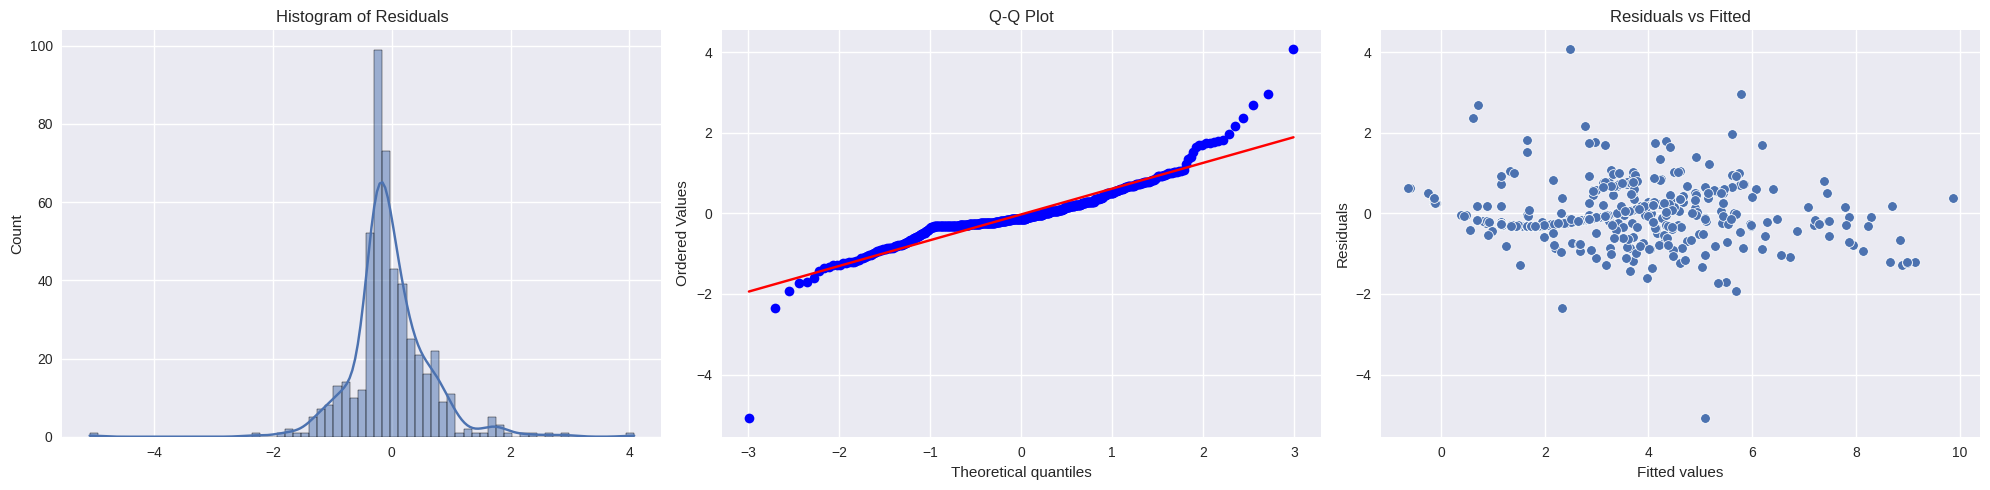

Shapiro-Wilk test:
ShapiroResult(statistic=0.8790093491508828, pvalue=2.0404127961333537e-19)

Skewness: 0.1624791480927227
Kurtosis: 9.802464412636787

Number of outliers: 7


In [12]:
# Check the residuals of the OLS model

# Load the saved model data
with open('model_data.pkl', 'rb') as f:
    model_data = pickle.load(f)

# Access y_test and y_pred
y_test = model_data['y_test']
y_pred = model_data['y_pred']

# Calculate residuals
residuals = y_test - y_pred

# 1. Plot residuals
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

# Histogram
sns.histplot(residuals, kde=True, ax=ax1)
ax1.set_title('Histogram of Residuals')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot')

# Residuals vs Fitted
sns.scatterplot(x=y_pred, y=residuals, ax=ax3)
ax3.set_title('Residuals vs Fitted')
ax3.set_xlabel('Fitted values')
ax3.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# 2. Statistical tests
print("Shapiro-Wilk test:")
print(stats.shapiro(residuals))

# 3. Skewness and Kurtosis
print("\nSkewness:", stats.skew(residuals))
print("Kurtosis:", stats.kurtosis(residuals))

# 4. Identify outliers
z_scores = np.abs(stats.zscore(residuals))
outliers = np.where(z_scores > 3)
print(f"\nNumber of outliers: {len(outliers[0])}")

### Random Forrest
Let's try a Random Forrest Regressor as a comparison.

In [13]:
# Random Forrest model

def develop_rf_ltv_model(df):
    # Feature engineering
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['Date of last donation'] = pd.to_datetime(df['Date of last donation'])
    df['Date of first donation'] = pd.to_datetime(df['Date of first donation'])
    df['duration'] = (df['Date of last donation'] - df['Date of first donation']).dt.days
    df['Month of last donation'] = df['Date of last donation'].dt.month
    df['donation_frequency'] = df[[f'Total donations in {year}' for year in range(2017, 2024)]].gt(0).sum(axis=1)
    df['time_between_donations'] = df['duration'] / df['donation_frequency']
    df['time_between_donations'].replace(np.inf, np.nan, inplace=True)
    df['time_between_donations'].fillna(0, inplace=True)
    df['returning_donor'] = (df['Date of last donation'] != df['Date of first donation']).astype(int)

    # One-hot encode donor segments, dropping Segment_Small to avoid multicollinearity
    segment_dummies = pd.get_dummies(df['Donor_Segment'], prefix='Segment', drop_first=False)
    segment_dummies = segment_dummies.drop('Segment_Small', axis=1)
    df = pd.concat([df, segment_dummies], axis=1)

    # Standardize 'duration'
    scaler = StandardScaler()
    df['duration_scaled'] = scaler.fit_transform(df[['duration']])

    # Log-transform Amount of first donation and avg_annual_donation
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['log_avg_annual_donation'] = np.log1p(df['avg_annual_donation'])

    # Prepare features and target
    features = ['log_amount_of_first_donation', 'recurring', 'returning_donor',
                'duration_scaled', 'Segment_Medium', 'Segment_Large']
    X = df[features]
    y = df['log_avg_annual_donation']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Random Forest Model Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")

    # Feature importance
    feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
    print("\nFeature Importance:")
    print(feature_importance.sort_values('importance', ascending=False))

    return rf_model

# Develop the Random Forest LTV model
rf_model = develop_rf_ltv_model(df)

Random Forest Model Results:
Mean Squared Error: 0.4271197880249768
R-squared Score: 0.8814493364523242

Feature Importance:
                        feature  importance
0  log_amount_of_first_donation    0.568184
3               duration_scaled    0.343510
4                Segment_Medium    0.062303
5                 Segment_Large    0.013284
2               returning_donor    0.006640
1                     recurring    0.006079


### Gradient Boosting
Let's try a Gradient Boosting Regressor as a comparison.

In [14]:
# Gradient Boosting model

def develop_gb_ltv_model(df):
    # Feature engineering
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['Date of last donation'] = pd.to_datetime(df['Date of last donation'])
    df['Date of first donation'] = pd.to_datetime(df['Date of first donation'])
    df['duration'] = (df['Date of last donation'] - df['Date of first donation']).dt.days
    df['Month of last donation'] = df['Date of last donation'].dt.month
    df['donation_frequency'] = df[[f'Total donations in {year}' for year in range(2017, 2024)]].gt(0).sum(axis=1)
    df['time_between_donations'] = df['duration'] / df['donation_frequency']
    df['time_between_donations'].replace(np.inf, np.nan, inplace=True)
    df['time_between_donations'].fillna(0, inplace=True)
    df['returning_donor'] = (df['Date of last donation'] != df['Date of first donation']).astype(int)

    # One-hot encode donor segments, dropping Segment_Small to avoid multicollinearity
    segment_dummies = pd.get_dummies(df['Donor_Segment'], prefix='Segment', drop_first=False)
    segment_dummies = segment_dummies.drop('Segment_Small', axis=1)
    df = pd.concat([df, segment_dummies], axis=1)

    # Standardize 'duration'
    scaler = StandardScaler()
    df['duration_scaled'] = scaler.fit_transform(df[['duration']])

    # Log-transform Amount of first donation and avg_annual_donation
    df['log_amount_of_first_donation'] = np.log1p(df['Amount of first donation'])
    df['log_avg_annual_donation'] = np.log1p(df['avg_annual_donation'])

    # Prepare features and target
    features = ['log_amount_of_first_donation', 'recurring', 'returning_donor',
                'duration_scaled', 'Segment_Medium', 'Segment_Large',]
    X = df[features]
    y = df['log_avg_annual_donation']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Gradient Boosting model
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = gb_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Gradient Boosting Model Results:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")

    # Feature importance
    feature_importance = pd.DataFrame({'feature': features, 'importance': gb_model.feature_importances_})
    print("\nFeature Importance:")
    print(feature_importance.sort_values('importance', ascending=False))

    return gb_model

# Develop the Gradient Boosting LTV model
gb_model = develop_gb_ltv_model(df)

Gradient Boosting Model Results:
Mean Squared Error: 0.38350870081493876
R-squared Score: 0.8935539578530147

Feature Importance:
                        feature  importance
0  log_amount_of_first_donation    0.576453
3               duration_scaled    0.352440
4                Segment_Medium    0.047835
5                 Segment_Large    0.013907
1                     recurring    0.005328
2               returning_donor    0.004037


In [15]:
def predict_ltv_rf(model, first_donation, recurring, returning_donor, duration, segment):
    # Prepare input data
    input_data = {
        'log_amount_of_first_donation': np.log1p(first_donation),
        'recurring': recurring,
        'returning_donor': returning_donor,
        'duration_scaled': (duration - df['duration'].mean()) / df['duration'].std(),
        'Segment_Medium': 1 if segment == 'Medium' else 0,
        'Segment_Large': 1 if segment == 'Large' else 0,
    }

    input_df = pd.DataFrame([input_data])

    # Predict average annual donation (log-transformed)
    log_avg_annual_donation = model.predict(input_df)[0]

    # Convert back from log scale
    avg_annual_donation = np.expm1(log_avg_annual_donation)

    # Estimate remaining lifespan (capped at 10 years to be more realistic)
    remaining_lifespan = min(10, 1 / (1 - retention_rates[segment]))

    # Calculate LTV
    ltv = avg_annual_donation * remaining_lifespan

    return ltv

# Example usage
rf_ltv = predict_ltv_rf(rf_model, first_donation=500, recurring=1, returning_donor=1, duration=365, segment='Small')
gb_ltv = predict_ltv_rf(gb_model, first_donation=500, recurring=1, returning_donor=1, duration=365, segment='Small')

print(f"Random Forest LTV prediction: ${rf_ltv:.2f}")
print(f"Gradient Boosting LTV prediction: ${gb_ltv:.2f}")

Random Forest LTV prediction: $325.87
Gradient Boosting LTV prediction: $384.46


The Random Forrest and Gradient Boosting perform similarly to the OLS in terms of model fit. The LTV projections appear to be too low. We shall use the OLS for its ease of interpretability and superior LTV predictions.

### Segment Classifier

In [16]:
# Train a classifier to predict donor segments

def train_segment_classifier(df):
    """
    Train a classifier to predict donor segments based on various features.
    """
    # Prepare features for the classifier
    classification_features = ['log_amount_of_first_donation', 'returning_donor', 'recurring', 'duration', 'Month of last donation']
    classification_target = 'Donor_Segment'

    X = df[classification_features]
    y = df[classification_target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    print("Segment Classifier Performance:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({'Feature': classification_features, 'Importance': clf.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Function to predict segment
    def predict_segment(first_donation, recurring, returning_donor, duration, month_of_last_donation):
        log_first_donation = np.log1p(first_donation)
        input_data = [[log_first_donation, returning_donor, recurring, duration, month_of_last_donation]]
        return clf.predict(input_data)[0]

    return predict_segment, clf

# Train the segment classifier
predict_segment, segment_classifier = train_segment_classifier(df)

def test_classification_boundaries(predict_segment):
    test_amounts = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    for amount in test_amounts:
        segment = predict_segment(amount, 1, 1, 365, 12)
        print(f"First donation: ${amount:,}, Predicted segment: {segment}")

print("\nTesting classification boundaries:")
test_classification_boundaries(predict_segment)

# Example usage
print("\nExample segment prediction:")
print(predict_segment(1000, 1, 1, 365, 12))  # Predict segment for a $X first donation, recurring, returning, 365 days duration, December

Segment Classifier Performance:
              precision    recall  f1-score   support

       Large       0.50      1.00      0.67         1
      Medium       0.79      0.50      0.61        30
       Small       0.97      0.99      0.98       474

    accuracy                           0.96       505
   macro avg       0.75      0.83      0.75       505
weighted avg       0.96      0.96      0.96       505


Feature Importance:
                        Feature  Importance
0  log_amount_of_first_donation    0.535597
3                      duration    0.309403
4        Month of last donation    0.095917
1               returning_donor    0.032556
2                     recurring    0.026528

Testing classification boundaries:
First donation: $100, Predicted segment: Small
First donation: $500, Predicted segment: Small
First donation: $1,000, Predicted segment: Small
First donation: $5,000, Predicted segment: Medium
First donation: $10,000, Predicted segment: Medium
First donation: $50,00

## Campaign Evaluation

We applied our LTV model to evaluate a recent advertising campaign:
- Estimated the LTV of donors acquired through the campaign
- Compared the total projected LTV to the campaign cost
- Analyzed the distribution of new donors across segments

This analysis provides insights into the effectiveness of the campaign and can inform future marketing strategies.

In [17]:
# Load and clean the advertising campaign data

def load_and_clean_campaign_data(file_path):
    """Load and clean the campaign data."""
    campaign_data = pd.read_csv(file_path)

    # Rename column
    campaign_data = campaign_data.rename(columns={'Was their first donation an automatically-recurring transaction?': 'recurring'})

    # Convert dollar columns to numerical (float)
    dollar_columns = ['Donation amount']

    def dollar_to_float(dollar_str):
        if isinstance(dollar_str, str):
            return round(float(dollar_str.replace('$', '').replace(',', '')), 2)
        return dollar_str

    for column in dollar_columns:
        campaign_data[column] = campaign_data[column].apply(dollar_to_float)

    # Convert date columns to datetime
    date_columns = ['Donation date', 'Date of first donation', 'Date of last donation']
    campaign_data[date_columns] = campaign_data[date_columns].apply(pd.to_datetime, errors='coerce')

    return campaign_data

In [18]:
# Estimating LTV for campaign data

def estimate_campaign_ltv(campaign_data, historical_data, avg_donation_model, segment_classifier, retention_rates):
    """
    Estimate Lifetime Value (LTV) for donors in the campaign data.
    """
    # Prepare campaign data
    campaign_data['Amount of first donation'] = campaign_data['Donation amount']
    campaign_data['Date of first donation'] = pd.to_datetime(campaign_data['Date of first donation'])
    campaign_data['Date of last donation'] = pd.to_datetime(campaign_data['Date of last donation'])
    campaign_data['duration'] = (campaign_data['Date of last donation'] - campaign_data['Date of first donation']).dt.days / 365.25
    campaign_data['Month of last donation'] = campaign_data['Date of last donation'].dt.month
    campaign_data['log_amount_of_first_donation'] = np.log1p(campaign_data['Amount of first donation'])

    # Check if the campaign donor matches historical data donor
    campaign_data = campaign_data.merge(historical_data[['Unique donor ID', 'Total Gifts']],
                                        on='Unique donor ID', how='left', suffixes=('', '_historical'))
    campaign_data['returning_donor'] = np.where(campaign_data['Total Gifts'].notnull(), 1, 0)
    campaign_data['Total Gifts'] = campaign_data['Total Gifts'].fillna(0)

    # Prepare data for classification
    classification_features = ['log_amount_of_first_donation', 'returning_donor', 'recurring', 'duration', 'Month of last donation']
    X_campaign_classification = campaign_data[classification_features]

    # Predict segments
    campaign_data['Predicted_Segment'] = segment_classifier.predict(X_campaign_classification)

    # Adjust segment prediction based on donation amount
    def adjust_segment(row):
        if row['Amount of first donation'] > 10000:
            return 'Large'
        elif row['Amount of first donation'] > 1000:
            return 'Medium'
        else:
            return row['Predicted_Segment']

    campaign_data['Predicted_Segment'] = campaign_data.apply(adjust_segment, axis=1)

    # Create dummy variables for segments
    segment_dummies = pd.get_dummies(campaign_data['Predicted_Segment'], prefix='Segment')
    campaign_data = pd.concat([campaign_data, segment_dummies], axis=1)
    campaign_data['Segment_Medium'] = campaign_data.get('Segment_Medium', 0)
    campaign_data['Segment_Large'] = campaign_data.get('Segment_Large', 0)

    # Standardize 'duration'
    scaler = StandardScaler()
    campaign_data['duration_scaled'] = scaler.fit_transform(campaign_data[['duration']])

    # Prepare data for average annual donation prediction
    features = ['log_amount_of_first_donation', 'recurring',
                'returning_donor', 'duration_scaled', 'Segment_Medium', 'Segment_Large']
    X_campaign = campaign_data[features]
    X_campaign = sm.add_constant(X_campaign)

    # Predict average annual donation
    campaign_data['estimated_log_average_annual_donation'] = avg_donation_model.predict(X_campaign).astype(float)
    # print("estimated_log_average_annual_donation:")
    # print(campaign_data['estimated_log_average_annual_donation'].head())
    # print(campaign_data['estimated_log_average_annual_donation'].dtype)
    campaign_data['model_estimated_annual_donation'] = np.exp(campaign_data['estimated_log_average_annual_donation'])
    # print("model_estimated_annual_donation:")
    # print(campaign_data['model_estimated_annual_donation'].head())
    # print(campaign_data['model_estimated_annual_donation'].dtype)

    # Adjust estimated average annual donation
    def adjust_estimated_donation(row):
        if row['returning_donor'] == 1:
            # For returning donors, use a weighted average of historical and model predictions
            historical_avg = row['Total Gifts'] / max(row['duration'], 1)  # Avoid division by zero
            weight = min(row['duration'] / 3, 1)  # Cap the weight at 1 for durations > 3 years
            weighted_avg = (weight * historical_avg) + ((1 - weight) * row['model_estimated_annual_donation'])
            return max(weighted_avg, row['Amount of first donation'])
        else:
            # For new donors, use max of model prediction and first donation amount
            return max(row['model_estimated_annual_donation'], row['Amount of first donation'])

    campaign_data['estimated_average_annual_donation'] = campaign_data.apply(adjust_estimated_donation, axis=1)

    # Estimate remaining lifespan
    def estimate_remaining_lifespan(segment):
        if segment in retention_rates:
            retention_rate = retention_rates[segment]
            return 1 / (1 - retention_rate) if retention_rate < 1 else float('inf')
        return 0

    campaign_data['estimated_remaining_lifespan'] = campaign_data['Predicted_Segment'].apply(estimate_remaining_lifespan)

    # Calculate LTV
    def calculate_ltv(row):
      try:
          future_value = row['estimated_average_annual_donation'] * row['estimated_remaining_lifespan']
          if row['returning_donor'] == 1:
              # For returning donors, only consider the additional value generated
              return future_value
          else:
              # For new donors, include the first donation amount
              return row['Amount of first donation'] + future_value
      except Exception as e:
          print(f"Error calculating LTV for row: {row}")
          print(f"Error: {str(e)}")
          return 0

    campaign_data['Additional_LTV'] = campaign_data.apply(calculate_ltv, axis=1)

    return campaign_data


def evaluate_campaign(campaign_data, campaign_cost):
    """
    Evaluate the campaign's performance based on estimated additional LTV.
    """
    # Calculate the total of first donations from the campaign
    campaign_donations = campaign_data['Amount of first donation'].sum()

    # Calculate the additional LTV (excluding historical donations)
    additional_ltv = campaign_data['Additional_LTV'].sum()

    total_campaign_value = additional_ltv
    roi = (total_campaign_value - campaign_cost) / campaign_cost

    print(f"Campaign Donations: ${campaign_donations:.2f}")
    print(f"Additional Projected LTV: ${additional_ltv:.2f}")
    print(f"Total Campaign Value: ${total_campaign_value:.2f}")
    print(f"Campaign Cost: ${campaign_cost:.2f}")
    print(f"Campaign Profit: ${(total_campaign_value - campaign_cost):.2f}")
    print(f"Campaign ROI: {roi:.2%}")

    return total_campaign_value, roi

# Load and clean campaign data
campaign_data = load_and_clean_campaign_data('/content/campaign_data.csv')

# Estimate LTV for campaign data
campaign_data_with_ltv = estimate_campaign_ltv(campaign_data, df, avg_donation_model, segment_classifier, retention_rates)

# Evaluate campaign performance
campaign_cost = 10000  # Replace with actual campaign cost
campaign_revenue, campaign_roi = evaluate_campaign(campaign_data_with_ltv, campaign_cost)

# Display detailed campaign data
print("\nDetailed Campaign Data:")
campaign_data_with_ltv['Total_LTV'] = campaign_data_with_ltv['Additional_LTV'] + campaign_data_with_ltv['Total Gifts']
display_columns = ['Unique donor ID', 'Amount of first donation', 'Predicted_Segment', 'duration', 'returning_donor', 'Total Gifts', 'estimated_average_annual_donation', 'estimated_remaining_lifespan', 'Additional_LTV', 'Total_LTV']
print(campaign_data_with_ltv[display_columns])

Campaign Donations: $3928.36
Additional Projected LTV: $11742.08
Total Campaign Value: $11742.08
Campaign Cost: $10000.00
Campaign Profit: $1742.08
Campaign ROI: 17.42%

Detailed Campaign Data:
       Unique donor ID  Amount of first donation Predicted_Segment  duration  \
0   0031Y00005xkaxlQAA                    100.00             Small  3.096509   
1   0031Y000061wiJRQAY                     25.00             Small  0.000000   
2   003i000002hGnPLAA0                     25.00             Small  0.000000   
3   003i000003vdlx9AAA                     51.36             Small  0.000000   
4   0031Y000054HQp7QAG                      5.00             Small  6.600958   
5   003i000003NZcK0AAL                     10.00             Small  0.000000   
6   0031Y00005WVIWcQAP                   1100.00            Medium  0.000000   
7   0031Y000054HRDbQAO                     12.00             Small  0.000000   
8   0031Y000061wiJRQAY                    100.00             Small  0.035592   
9   00

According to our model, the campaign was a success, producing new donors with an LTV higher than the campaign costs.

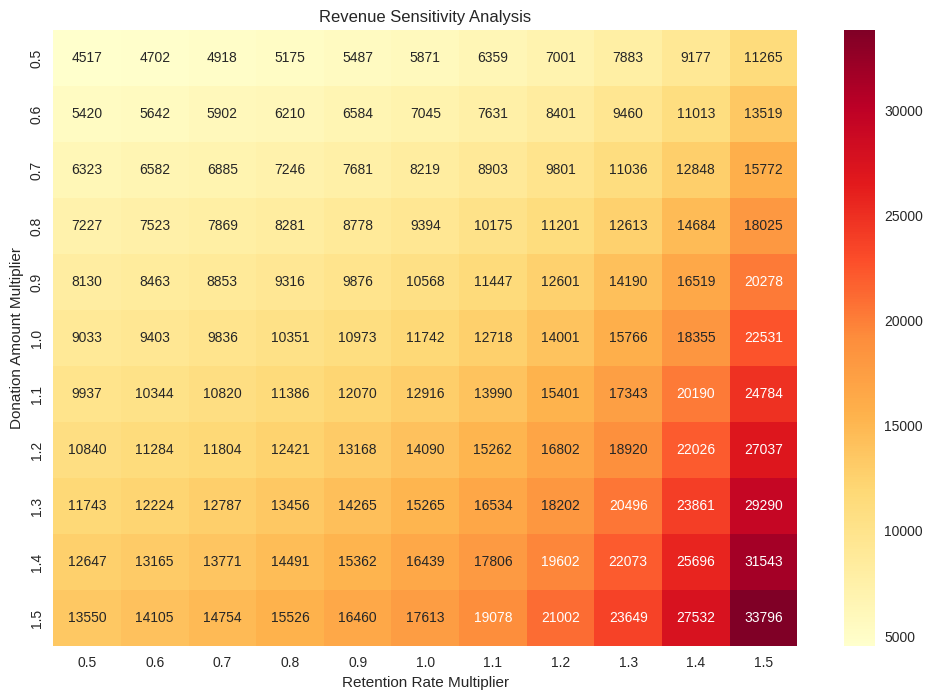

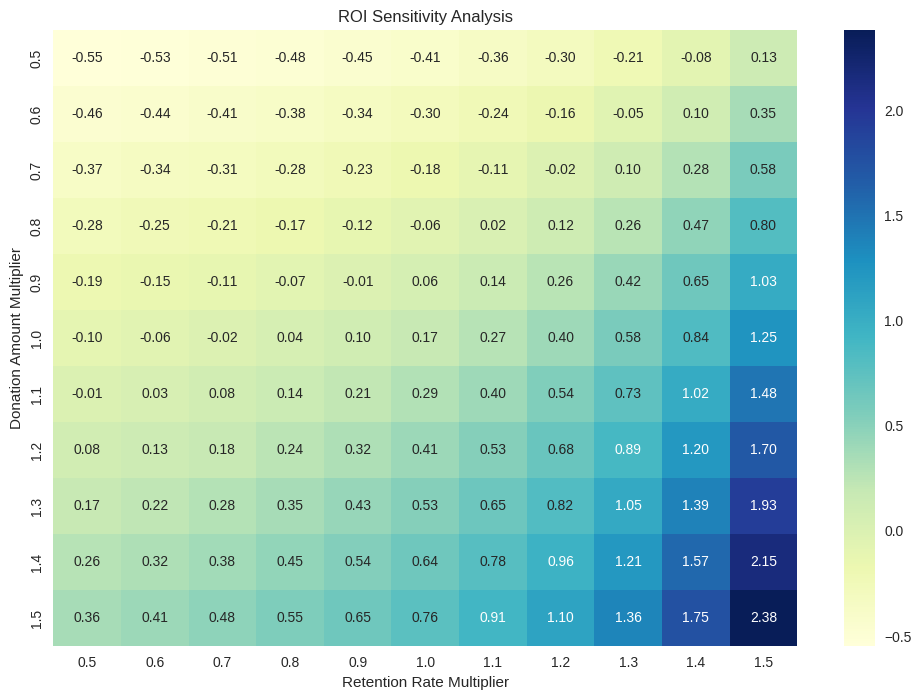

In [19]:
# Sensitivity Analysis

def perform_sensitivity_analysis(campaign_data, campaign_cost, base_retention_rates):
    donation_multipliers = np.arange(0.5, 1.51, 0.1)
    retention_multipliers = np.arange(0.5, 1.51, 0.1)

    revenue_matrix = np.zeros((len(donation_multipliers), len(retention_multipliers)))
    roi_matrix = np.zeros((len(donation_multipliers), len(retention_multipliers)))

    for i, d_mult in enumerate(donation_multipliers):
        for j, r_mult in enumerate(retention_multipliers):
            # Adjust retention rates
            adjusted_retention_rates = {k: min(v * r_mult, 0.99) for k, v in base_retention_rates.items()}

            # Recalculate LTV with adjusted parameters
            adjusted_data = estimate_campaign_ltv(campaign_data.copy(), df, avg_donation_model, segment_classifier, adjusted_retention_rates)
            adjusted_data['Additional_LTV'] *= d_mult

            # Calculate revenue and ROI
            revenue = adjusted_data['Additional_LTV'].sum()
            roi = (revenue - campaign_cost) / campaign_cost

            revenue_matrix[i, j] = revenue
            roi_matrix[i, j] = roi

    # Plot Revenue Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(revenue_matrix, xticklabels=retention_multipliers.round(2), yticklabels=donation_multipliers.round(2),
                cmap='YlOrRd', annot=True, fmt='.0f')
    plt.title('Revenue Sensitivity Analysis')
    plt.xlabel('Retention Rate Multiplier')
    plt.ylabel('Donation Amount Multiplier')
    plt.show()

    # Plot ROI Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(roi_matrix, xticklabels=retention_multipliers.round(2), yticklabels=donation_multipliers.round(2),
                cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('ROI Sensitivity Analysis')
    plt.xlabel('Retention Rate Multiplier')
    plt.ylabel('Donation Amount Multiplier')
    plt.show()

# Perform sensitivity analysis
perform_sensitivity_analysis(campaign_data, campaign_cost, retention_rates)

The sensitivity analysis explores how changes in donation amounts and retention rates impact revenue and ROI.

**Revenue Sensitivity**
- Revenue increases as both donation amounts and retention rates increase, as shown by the color gradient from yellow to dark red.
- The impact is multiplicative - increases in both factors lead to exponential revenue growth.
- Retention rate improvements have a more pronounced effect on revenue than equivalent increases in donation amounts, particularly at higher levels.

**ROI Sensitivity**
- ROI improves (shifts from yellow to blue) as donation amounts and retention rates increase.
- The breakeven point (ROI = 0) occurs around the middle of the chart, with slight variations depending on the combination of factors.
- Maximizing both donation amounts and retention rates is crucial for achieving the highest ROI (dark blue area).
- There's a clear transition from negative ROI (yellow) to positive ROI (green to blue) as the multipliers increase.

**Key Insights**
- Focusing on retention strategies may yield higher returns than solely pursuing larger donations.
- Small improvements in both factors can push borderline campaigns into profitability.
- Highly successful campaigns (bottom-right corner) can achieve exponentially better results, emphasizing the potential of optimizing both dimensions.
- The analysis provides a tool for setting targets and evaluating the potential impact of different fundraising strategies.

This sensitivity analysis underscores the importance of a balanced approach to fundraising, optimizing both donation sizes and donor retention for maximum financial impact.

## Conclusion

This analysis provides a view of donor behavior and value for the nonprofit organization. Key takeaways include:

1. The importance of donor segmentation in understanding giving patterns and tailoring strategies
2. The significant impact of donor retention on long-term fundraising success
3. The presence of strong seasonal trends in donations, which can inform campaign timing
4. The value of a data-driven approach to estimating donor Lifetime Value

The LTV model developed in this project offers a tool for evaluating fundraising efforts and making decisions about donor acquisition and retention strategies. Future work could focus on refining the model with additional data, exploring machine learning approaches for donor segmentation, and developing personalized engagement strategies based on individual donor characteristics.